# Needed packages and imports

In [ ]:
pip install python-snappy # Dependency of pandavro

     |████████████████████████████████| 61kB 2.2MB/s 


In [ ]:
pip install pandavro # Needed for converting avro into pandas dataframe

     |████████████████████████████████| 2.3MB 5.2MB/s 
  Created wheel for pandavro: filename=pandavro-1.6.0-cp37-none-any.whl size=4557 sha256=314c58a33e13a4ca51fdf33d598865ec65852f0891ea4cfb41c9217a826363ca
  Stored in directory: /root/.cache/pip/wheels/b4/15/34/1651bfefb11129c79c892b07e96c0e7a1eb79f702b5078b71e
Successfully built pandavro


In [ ]:
pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 5.2MB/s 
     |████████████████████████████████| 645kB 17.4MB/s 
     |████████████████████████████████| 358kB 21.5MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 174kB 36.9MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 1.2MB 37.1MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 706kB 40.6MB/s 


In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 3.4MB 6.4MB/s 


In [ ]:
pip install langdetect

     |████████████████████████████████| 983kB 5.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=72e37e6ab72006813c86969e390afdb29aa4b07ad01f2a7e2c24f7b3b618f9fb
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
pip install ktrain

     |████████████████████████████████| 25.3MB 1.7MB/s 
     |████████████████████████████████| 6.8MB 34.6MB/s 
     |████████████████████████████████| 266kB 46.1MB/s 
     |████████████████████████████████| 1.9MB 44.8MB/s 
     |████████████████████████████████| 471kB 41.5MB/s 
     |████████████████████████████████| 901kB 21.9MB/s 
     |████████████████████████████████| 3.3MB 32.5MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=1cddd1463a6ed791e9bdca0c888e1cf4b1fe25f05cb3a795911268aeab9bae38
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for syntok: filename=syntok-1.3.1-cp37-none-any.whl size=20919 sha256=7a7534a06ff9365caa1cd20cdd05ff91d43174ec52a023a1ecc09a00d66f0d92
  Stored in directory: /root/.cache/pip/wheels/51/c6/a4/be1920586c49469846bcd2888200bdecfe109ec421dab9be2d
  Created wheel for seqeval: filename=seqeval-0.0.19-cp37-none-any.whl size=9919 sha256=

In [ ]:
pip install keras-bert

In [ ]:
%load_ext tensorboard

In [ ]:
from datetime import datetime
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pickle

import keras_bert as kbert
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.utils import np_utils

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from langdetect import detect

import official.nlp.bert.tokenization as tokenization

import requests
import sys
import zipfile
import codecs

from keras_bert import Tokenizer as BERT_Tokenizer

import ktrain

# Preprocessing dependencies
from pandavro import read_avro
import snappy
import re
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Input cleanup

In [ ]:
path = "<path to the dataset>"
df2 = read_avro(path)
print("Read dataframe of shape: ", df2.shape)
df2.head()

Read dataframe of shape:  (22217, 2)


,url,content
0,http://4wsplatform.org/gallery/identity-manage...,"<!DOCTYPE html>\n\n<html lang=""it-IT"">\n<head>..."
1,https://www.aerosal.it/en/aerosalmed/,"<!DOCTYPE html>\n\n<html lang=""en-US"">\n<head>..."
2,http://acmestre1929.it/comunicati-stampa/mauro...,<!DOCTYPE html>\n\n<!--[if IE 7]>\n<html class...
3,http://abruzzotartufi.com/contacts/,<!DOCTYPE html>\n\n<!-- paulirish.com/2008/con...
4,http://24x1ora.csivb.net/24x1-team-1.html,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T..."


In [ ]:
MAX_SEQUENCE_LEN = 512 # This limit depends on the BERT model used, and will be used to split the page contents accordingly

In [ ]:
def cleanup(raw): # Function that cleans up the html removing tags, scripts and styling

  soup = BeautifulSoup(raw, features = "html.parser")

  for script in soup(["script", "style"]): # Removing content that isn't text
    script.extract()

  # Getting the text, removing blank lines and spaces
  text = soup.get_text()
  lines = (line.strip() for line in text.splitlines())
  clean_lines = (l for l in lines if not(l == "") and len(l.split()) > 1)
  words = []
  for l in clean_lines:
    for word in l.split(" "):
      words.append(word.strip())
  text = ' '.join(word for word in words if word) # It's also possible to concatenate /n
  return text

def takeCenter(content):
  words = len(content.split())
  newContent = content.split()
  if words > MAX_SEQUENCE_LEN:
    toskip = (words - MAX_SEQUENCE_LEN)//2
    newContent = newContent[toskip:toskip+512]
  content = ' '.join(newContent)
  return content

def clean_text(text):
  text = re.sub("'", "", text)
  text = re.sub("(\\W)+", " ", text)
  filtered_sentence = text
  return filtered_sentence

def splitRow(df, tqdm_activated = True):
  counter = 0
  df_size = df.shape[0]
  for index, row in tqdm(df.iterrows(), total = df.shape[0], disable = not(tqdm_activated)):
    length = len(row['content'])
    if length > MAX_SEQUENCE_LEN:
      splits = (length // MAX_SEQUENCE_LEN) - 1
      for i in range(splits):
        counter += 1
        newContent = row['content'][(i+1)*MAX_SEQUENCE_LEN : (i+2)*MAX_SEQUENCE_LEN]
        newTarget = row['target']
        name = str(df_size + counter)
        temp = {'url': row['url'],'content': newContent, 'target': newTarget}
        ser = pd.Series(data=temp, index=['url','content', 'target'], name = name)
        df = df.append(ser)
  print(f"Splitted a total of %d strings" %(counter))
  return df

def oldIsTeamPage(url):
  people_pattern = "(?i).*(team|[^a-z]conta(tti|cts?)[^a-z]|chi.?siamo|about|[^a-z]about[^a-z]|comitato|management|direzione|squadra|person(al)?e|staff|people|organi(gramma|sm)|[^a-z]board[^a-z]|[^a-z]soci[^a-z]|consiglio[ -_]?(di[ -_]?amministrazione)?).*"
  blog_url_pattern = "(?i)(blog|news|notizie|rss|press.release|investors?.relation|investors?|comunicati.stampa)"
  re_people = re.compile(people_pattern)
  re_blog = re.compile(blog_url_pattern)

  if url == "":
    return 0
  else:
    return 1 if re_people.search(url) is not None and not(re_blog.search(url)) else 0

def isTeamPage(url): # Function that emulates how Rastrello checks if a page contains a team or not (removed 'us' which is too commong in links and makes many mistakes)
  people_pattern = "(?i)(chi.?siamo)|(/team/)$"
  #people_pattern = "(?i).*(team|[^a-z]conta(tti|cts?)[^a-z]|chi.?siamo|about|[^a-z]about[^a-z]|comitato|management|direzione|squadra|person(al)?e|staff|people|organi(gramma|sm)|[^a-z]board[^a-z]|[^a-z]soci[^a-z]|consiglio[ -_]?(di[ -_]?amministrazione)?).*"
  blog_url_pattern = "(?i)(blog|news|notizie|rss|press.release|investors?.relation|investors?|comunicati.stampa)"
  re_people = re.compile(people_pattern)
  re_blog = re.compile(blog_url_pattern)

  if url == "":
    return 0
  else:
    return 1 if re_people.search(url) is not None and not(re_blog.search(url)) else 0

def preprocessing_avro(avro, tqdm_activated = True): # Function that combines all the ones above (specific to how Rastrello avro files)
  df = avro

  try:
    df = df.drop(columns = ["signature","status","db_status","timestamp","modified","retries","debug"])
  except:
    pass

  if 'target' in df.columns:
    pass
  else:
    df['target'] = list(map(isTeamPage, tqdm(df['url'], disable = not(tqdm_activated))))
  df['content'] = list(map(cleanup, tqdm(df['content'], disable = not(tqdm_activated))))
  df['content'] = df.content.apply(clean_text)
  df = df[df['content'] != ""]
  df['content'] = list(map(takeCenter, tqdm(df['content'], disable = not(tqdm_activated))))

  #df = splitRow(df, tqdm_activated = tqdm_activated)
  error_pattern = "(?i)(page not found|error 404|server error|pagina non trovata|404 not found|not found)"
  re_error = re.compile(error_pattern)
  counter = 0
  for row in tqdm(df.iterrows(), disable = not(tqdm_activated)):
    if re_error.search(row[1]['content']) is not None:
      counter += 1
      df = df.drop(row[0])
  print("\n\nRemoved a total of", counter, "error pages\n")
  return df

In [ ]:
processed_avro = preprocessing_avro(df)
print("Resulting shape and columns: ", processed_avro.shape, processed_avro.columns)
print("Example of entry: \n", processed_avro.iloc[0])

In [ ]:
# Save the dataframe so that there's no need to build it again each time

df.to_pickle("<path to save your dataframe>")

In [ ]:
# And corresponding load function

processed_avro = pd.read_pickle("<path to save your dataframe>")
print("Resulting shape and columns: ", processed_avro.shape, processed_avro.columns)
print("Example of entry: \n", processed_avro.iloc[0])

Resulting shape and columns:  (106266, 3) Index(['url', 'content', 'target'], dtype='object')
Example of entry: 
 url              https://www.caseificiolongo.it/it/chi-siamo
content    ottenuti nel corso degli anni sono la prova de...
target                                                     1
Name: 1, dtype: object


# Dataset preparation

In [ ]:
# Notebook characteristics and GPUs

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
# Splitting between training and testing set

np.random.seed(seed=42)
mask = np.random.rand(processed_avro.shape[0]) < 0.8
train_df = processed_avro[mask]
test_df = processed_avro[~mask]

print(f"Created a train dataset of shape %s and a test dataset of shape %s" %(train_df.shape, test_df.shape))

Most commond label:  0
Ratio:  1.1674775210779693


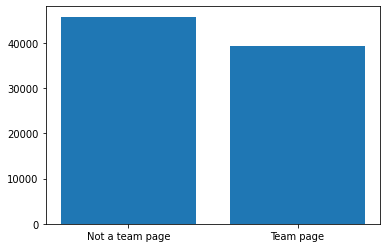

In [ ]:
# Visualizing the distribution in the training set

classes = train_df.target.unique()
counts = []

for i in classes:
  count = len(train_df[train_df.target == i])
  counts.append(count)

plt.bar(['Not a team page','Team page'], counts)
max_label = counts.index(max(counts))
ratio = max(counts)/min(counts)
print("Most commond label: ", max_label)
print("Ratio: ", ratio)
plt.show()

# Ktrain model

In [ ]:
pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-8f4fu7p4
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-8f4fu7p4
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106832 sha256=ffc4c9f2c088160d9bac68bd2360d4abc0edc8ddd5a244fcc32d3a5463b5ce4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mki5p5td/wheels/51/59/0a/0f48442b8d209583a4453580938d7ba2270aca40edacee6d45
Successfully built eli5


In [ ]:
# Preprocessing of the input and finding a max sequence length

text_lens = [len(i) for i in processed_avro['content']]
max_seq_len = max(text_lens)
max_seq_len = min(max_seq_len, MAX_SEQUENCE_LEN) # Maximum sequence length for small BERTs, it's needed to increase it or divide the inputs in some way to cover the whole content of the page

train_texts = train_df.content.values
test_texts = test_df.content.values

In [ ]:
# Label preprocessing

train_labels = train_df.target.values
test_labels = test_df.target.values

pos_count = 0
neg_count = 0
for l in train_labels:
  if l == 1:
    pos_count +=1
  else:
    neg_count +=1

ratio = 0
ratio = neg_count/pos_count

weights = {}
if(max_label == 0):
  weights = {0:1, 1:ratio}
else:
  weights = {0:ratio, 1:1}

encoder = LabelEncoder()
labels = tf.concat([train_labels, test_labels], axis = -1)
encoder.fit(labels)
encoded_Y_test = encoder.transform(test_labels)
encoded_Y_train = encoder.transform(train_labels)

# convert integers to dummy variables (i.e. one hot encoded)
Y_train = np_utils.to_categorical(encoded_Y_train)
Y_test = np_utils.to_categorical(encoded_Y_test)

In [ ]:
def filename_from_url(url):
    return os.path.split(url)[-1]

In [ ]:
BERT_URL = 'https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip'

def get_bert_model(lang='en'):
    home = os.path.expanduser('~')
    train_data = os.path.join(home, 'data')
    if not os.path.isdir(train_data):
        os.mkdir(train_data)
    bert_name = filename_from_url(BERT_URL)
    zip_fpath = os.path.join(train_data, bert_name)
    bert_path = os.path.join( train_data, os.path.splitext(bert_name)[0])
    if not os.path.isdir(bert_path) or \
       not os.path.isfile(os.path.join(bert_path, 'bert_config.json')) or\
       not os.path.isfile(os.path.join(bert_path, 'bert_model.ckpt.data-00000-of-00001')) or\
       not os.path.isfile(os.path.join(bert_path, 'bert_model.ckpt.index')) or\
       not os.path.isfile(os.path.join(bert_path, 'bert_model.ckpt.meta')) or\
       not os.path.isfile(os.path.join(bert_path, 'vocab.txt')):
        # download zip
        print('downloading pretrained BERT model (%s)...' % (BERT_URL))

        with open(zip_fpath, 'wb') as f:
            response = requests.get(BERT_URL, stream=True,  verify=False)
            total = response.headers.get('content-length')

            if total is None:
                f.write(response.content)
            else:
                downloaded = 0
                total = int(total)
                #print(total)
                for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                    downloaded += len(data)
                    f.write(data)
                    done = int(50*downloaded/total)
                    sys.stdout.write('\r[{}{}]'.format('█' * done, '.' * (50-done)))
                    sys.stdout.flush()

        # unzip
        print('\nextracting pretrained BERT model...')
        with zipfile.ZipFile(zip_fpath, 'r') as zip_ref:
            zip_ref.extractall(train_data)
        print('done.\n')

        # cleanup
        print('cleanup downloaded zip...')
        try:
            os.remove(zip_fpath)
            print('done.\n')
        except OSError:
            print('failed to cleanup/remove %s' % (zip_fpath))
    return bert_path

def bert_tokenize(docs, tokenizer, max_length, verbose=1):
    mb = range(1)
    pb = docs
    indices = []
    for i in mb:
        for doc in tqdm(pb):
            ids, segments = tokenizer.encode(doc, max_len=max_length)
            indices.append(ids)
    zeros = np.zeros_like(indices)
    return [np.array(indices), np.array(zeros)]

In [ ]:
class BERTPreprocessor():

    def __init__(self, maxlen, max_features, class_names=[], ngram_range=1, multilabel=None):
        self.c = class_names
        self.maxlen = maxlen
        self.lang = "it"
        self.max_features = max_features

        vocab_path = os.path.join(get_bert_model('it'), 'vocab.txt')
        token_dict = {}
        with codecs.open(vocab_path, 'r', 'utf8') as reader:
            for line in reader:
                token = line.strip()
                token_dict[token] = len(token_dict)
        tokenizer = BERT_Tokenizer(token_dict)
        self.tok = tokenizer
        self.tok_dct = dict((v,k) for k,v in token_dict.items())


    def get_tokenizer(self):
        return self.tok

    def preprocess(self, texts, y=None, mode='train', verbose=1):
        if mode == 'train' and y is None:
            raise ValueError('y is required when preprocessing the training set')

        x = bert_tokenize(texts, self.tok, self.maxlen, verbose=verbose)

        result = (x, y)
        return result

    def get_classes(self):
        return self.c

preproc = BERTPreprocessor(maxlen = MAX_SEQUENCE_LEN,
                           max_features = 20000,
                           class_names = ['No team', 'Team'])

downloading pretrained BERT model (https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.



In [ ]:
trn = preproc.preprocess(train_texts, Y_train, mode='train')
val = preproc.preprocess(test_texts, Y_test, mode='test')

100%|██████████| 21173/21173 [01:51<00:00, 190.29it/s]


In [ ]:
def build_bert(num_classes, maxlen, max_features, loss_func='categorical_crossentropy', activation = 'softmax', metrics=['accuracy'],  verbose=1, preproc=None):
    if preproc is None: raise ValueError('preproc is missing')
    lang = preproc.lang
    if lang is None: raise ValueError('lang is missing')
    config_path = os.path.join(get_bert_model(lang=lang), 'bert_config.json')
    checkpoint_path = os.path.join(get_bert_model(lang=lang), 'bert_model.ckpt')

    model = kbert.load_trained_model_from_checkpoint(
                                    config_path,
                                    checkpoint_path,
                                    training=True,
                                    trainable=True,
                                    seq_len=maxlen)
    inputs = model.inputs[:2]
    dense = model.get_layer('NSP-Dense').output
    outputs = tf.keras.layers.Dense(units=num_classes, activation=activation)(dense) # Rimosso Dropout
    model = tf.keras.Model(inputs, outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.2e-5)
    model.compile(loss=loss_func,
                  optimizer=opt,
                  metrics=metrics)
    return model

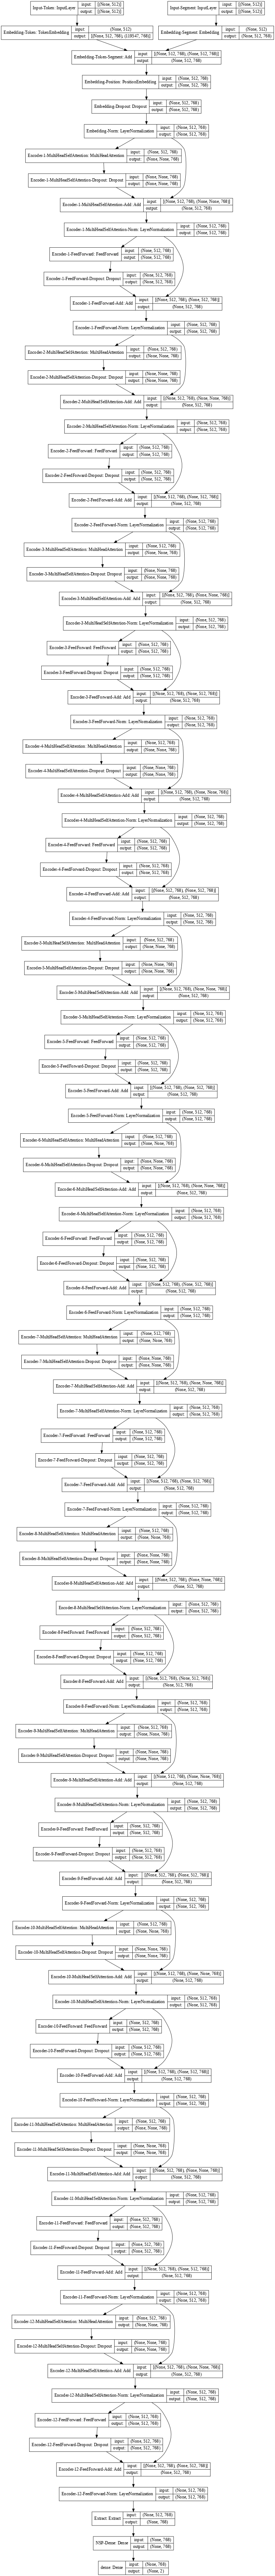

In [ ]:
model = build_bert(num_classes = 2, maxlen = 512, max_features = preproc.max_features, metrics = ['accuracy'], preproc = preproc)
tf.keras.utils.plot_model(model, show_shapes=True, dpi = 60)

In [ ]:
history = model.fit(
    x = trn[0],
    y = trn[1], 
    epochs = 2,
    batch_size = 8,
    validation_data = (val[0], val[1]),
    verbose = 1, 
)

Epoch 1/2
10637/10637 [==============================] - 14722s 1s/step - loss: 0.3315 - accuracy: 0.8516 - val_loss: 0.2090 - val_accuracy: 0.9175
Epoch 2/2
10264/10637 [===========================>..] - ETA: 8:16 - loss: 0.2004 - accuracy: 0.9215

In [ ]:
predictor = ktrain.get_predictor(model, preproc)

In [ ]:
print(test_texts)

['Chi siamo Casekontemporanee tel 0182 660697cell 393 3351851 346 7529831e mail info casekontemporanee it CasekontemporaneeAgenzia immobiliare con immobili residenziali e commerciali nella città di Alassio e zone limitrofe Chi siamo Chi siamo CaseKontemporanee significa Professionalità Concretezza e Trasparenza Questi tre capisaldi sono ormai la nostra filosofia di vita che ci accompagna dal 2002 anno in cui il nostro progetto ha preso vita Giorno dopo giorno come unico obiettivo abbiamo la vostra felicità e i vostri bisogni aiutandovi a realizzare il vostro sogno Trovare la CASA dei vostri Desideri La nostra conoscenza del territorio e dell ambiente circostante gioca da sempre a nostro favore e con essa sappiamo consigliare al meglio chi si affida a noi per costruire il proprio futuro CaseKontemporanee non è solo compravendita e affitti ma è anche RISTRUTTURAZIONE e ARREDO grazie alla Passione e alle Competenze di Maurizio che assieme al prezioso contributo del fratello Savio garantis

In [ ]:
y_pred = model.predict(val[0])
argmax_y_pred = y_pred.argmax(axis=1)
argmax_y_test = Y_test.argmax(axis=1)

cm = confusion_matrix(argmax_y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(argmax_y_test, argmax_y_pred, target_names=['No team', 'Team']))

In [ ]:
learner.view_top_losses(n=5, preproc=preproc)

----------
id:4452 | loss:9.66 | true:No team | pred:Team)

[CLS] chi sia ##mo affari ##dic ##uo ##re tog ##gle navigation chi sia ##mo il progetto le tu ##e doma ##nde le nos ##tre ri ##sp ##oste le tu ##e doma ##nde le nos ##tre ri ##sp ##oste dove pu ##oi chiede ##re quello che vu ##oi chi sia ##mo chi sia ##mo vale ##ria mari ##a vittoria pa ##olo ti ##zia ##na e tanti altri sia ##mo gli operator ##i del consul ##torio gi ##nec ##olog ##he os ##tet ##riche psi ##colo ##gi e assistent ##i sociali un gruppo di profession ##isti a cui pu ##oi chiede ##re aiuto per affrontare con pi ##u ser ##eni ##ta un momento particolare della tua vita in consul ##torio pu ##oi riceve ##re informazioni su diversi ar ##gom ##enti conosce ##re il proprio corpo e i suoi mu ##tam ##enti discu ##tere e far ##ti un idea tua sulla ses ##sua ##lita val ##utar ##e il metodo contra ##cce ##tti ##vo pi ##u adat ##to a te app ##ro ##fond ##ire il tuo rapporto con gli altri dia ##loga ##re sull amicizia e l amor

In [ ]:
page = 1
print(test_df['url'].iloc[page])
predictor.explain(test_texts[page])

https://www.carrozzeriaallecave.it/chi-siamo/


# Testing 

In [ ]:
#ITA
ita = pd.read_pickle("/content/drive/My Drive/setaccio/IT")
print("Resulting shape and columns: ", ita.shape, ita.columns)
X_ita = ita.content.values
v = preproc.preprocess(X_ita, mode='test')
y_pred = model.predict(v[0])
argmax_y_pred = y_pred.argmax(1)
argmax_y_test = np.asarray(ita['target'], dtype="int32")

cm = confusion_matrix(argmax_y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(argmax_y_test, argmax_y_pred, target_names=['No team', 'Team']))

In [ ]:
errors = np.where(argmax_y_pred != argmax_y_test)[0]
print("Total number of errors: ", len(errors))
print("\n")
for i in errors:
  print("Id: ", i)
  print("Url: ", ita.iloc[i]['url'])
  print("Is team page?", oldIsTeamPage(ita.iloc[i]['url']))
  print("Analyzed: ", ita.iloc[i]['content'][:512])
  print("Mistakely identified it as a", "TEAM page" if argmax_y_pred[i] == 1 else "NON-TEAM page", "[", argmax_y_pred[i], "]")
  print("\n")

In [ ]:
page = 30
print(ita['url'].iloc[page])
predictor.explain(X_ita[page])

In [ ]:
#ES
es = pd.read_pickle("/content/drive/My Drive/setaccio/ES")
print("Resulting shape and columns: ", es.shape, es.columns)
X_es = es.content.values
v = preproc.preprocess(X_es, mode='test')
y_pred = model.predict(v[0])
argmax_y_pred = y_pred.argmax(1)
argmax_y_test = np.asarray(es['target'], dtype="int32")

cm = confusion_matrix(argmax_y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(argmax_y_test, argmax_y_pred, target_names=['No team', 'Team']))

In [ ]:
errors = np.where(argmax_y_pred != argmax_y_test)[0]
print("Total number of errors: ", len(errors))
print("\n")
for i in errors:
  print("Id: ", i)
  print("Url: ", es.iloc[i]['url'])
  print("Is team page?", oldIsTeamPage(es.iloc[i]['url']))
  print("Analyzed: ", es.iloc[i]['content'][:512])
  print("Mistakely identified it as a", "TEAM page" if argmax_y_pred[i] == 1 else "NON-TEAM page", "[", argmax_y_pred[i], "]")
  print("\n")

In [ ]:
page = 267
print(es['url'].iloc[page])
predictor.explain(X_es[page])

In [ ]:
#EN
en = pd.read_pickle("/content/drive/My Drive/setaccio/EN")
print("Resulting shape and columns: ", en.shape, en.columns)
X_en = en.content.values
v = preproc.preprocess(X_en, mode='test')
y_pred = model.predict(v[0])
argmax_y_pred = y_pred.argmax(1)
argmax_y_test = np.asarray(en['target'], dtype="int32")

cm = confusion_matrix(argmax_y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(argmax_y_test, argmax_y_pred, target_names=['No team', 'Team']))

In [ ]:
errors = np.where(argmax_y_pred != argmax_y_test)[0]
print("Total number of errors: ", len(errors))
print("\n")
for i in errors:
  print("Id: ", i)
  print("Url: ", en.iloc[i]['url'])
  print("Is team page?", oldIsTeamPage(en.iloc[i]['url']))
  print("Analyzed: ", en.iloc[i]['content'][:512])
  print("Mistakely identified it as a", "TEAM page" if argmax_y_pred[i] == 1 else "NON-TEAM page", "[", argmax_y_pred[i], "]")
  print("\n")

In [ ]:
page = 282
print(en['url'].iloc[page])
predictor.explain(X_en[page])

In [ ]:
#FR
fr = pd.read_pickle("/content/drive/My Drive/setaccio/FR")
print("Resulting shape and columns: ", fr.shape, fr.columns)
X_fr = fr.content.values
v = preproc.preprocess(X_fr, mode='test')
y_pred = model.predict(v[0])
argmax_y_pred = y_pred.argmax(1)
argmax_y_test = np.asarray(fr['target'], dtype="int32")

cm = confusion_matrix(argmax_y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(argmax_y_test, argmax_y_pred, target_names=['No team', 'Team']))

In [ ]:
errors = np.where(argmax_y_pred != argmax_y_test)[0]
print("Total number of errors: ", len(errors))
print("\n")
for i in errors:
  print("Id: ", i)
  print("Url: ", fr.iloc[i]['url'])
  print("Is team page?", oldIsTeamPage(fr.iloc[i]['url']))
  print("Analyzed: ", fr.iloc[i]['content'][:512])
  print("Mistakely identified it as a", "TEAM page" if argmax_y_pred[i] == 1 else "NON-TEAM page", "[", argmax_y_pred[i], "]")
  print("\n")

In [ ]:
page = 287
print(fr['url'].iloc[page])
predictor.explain(X_fr[page])

In [ ]:
#DE
de = pd.read_pickle("/content/drive/My Drive/setaccio/DE")
print("Resulting shape and columns: ", de.shape, de.columns)
X_de = de.content.values
v = preproc.preprocess(X_de, mode='test')
y_pred = model.predict(v[0])
argmax_y_pred = y_pred.argmax(1)
argmax_y_test = np.asarray(de['target'], dtype="int32")

cm = confusion_matrix(argmax_y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(argmax_y_test, argmax_y_pred, target_names=['No team', 'Team']))

In [ ]:
errors = np.where(argmax_y_pred != argmax_y_test)[0]
print("Total number of errors: ", len(errors))
print("\n")
for i in errors:
  print("Id: ", i)
  print("Url: ", de.iloc[i]['url'])
  print("Is team page?", oldIsTeamPage(de.iloc[i]['url']))
  print("Analyzed: ", de.iloc[i]['content'][:512])
  print("Mistakely identified it as a", "TEAM page" if argmax_y_pred[i] == 1 else "NON-TEAM page", "[", argmax_y_pred[i], "]")
  print("\n")

In [ ]:
page = 136
print(de['url'].iloc[page])
predictor.explain(X_de[page])